In [2]:
class Card:
    
    def __init__(self, card_id=None):
        
        self._string_rep = None
        self._suit = None
        self._rank = None
        self._values = None
                
        if card_id is None:
            self.card_id = 0
            
        else:
            #if card id > 52, then take mod - this makes multi deck implementation easier (card_id:0 == card_id:52)
            self.card_id = card_id
            self.card_id_mod = card_id % 52
            
    def __repr__(self):
        
        if self._string_rep is None:
            self._string_rep = self.rank + self.suit
            
        return self._string_rep
            
    @property     
    def suit(self):
        
        if self._suit is None:
            suits = ['♣︎','♦︎','♥︎','♠︎']
            self._suit =  suits[self.card_id_mod//13]
            
        return self._suit
    
    @property     
    def rank(self):
        
        if self._rank is None:
            ranks = ['A'] + list(range(2,11)) + ['J','Q','K']
            self._rank =  str(ranks[self.card_id_mod%13])
            
        return self._rank
    
    
    @property
    def values(self): ###############################
        
        if self._values == None:
        
            rank_values_map = {'A': [1, 11],
                             '2': [2],
                             '3': [3],
                             '4': [4],
                             '5': [5],
                             '6': [6],
                             '7': [7],
                             '8': [8],
                             '9': [9],
                             '10': [10],
                             'J': [10],
                             'Q': [10],
                             'K': [10]}
            
            self._values = rank_values_map[self.rank]
            
        return self._values

In [3]:
class Deck:
    
    def __init__(self):
        
        from collections import deque 
        self.cards = deque([Card(i) for i in range(52)])
    
    def __repr__(self):
        
        from itertools import islice
        
        return '⎡' +  \
               '⎦  ⎡'.join([str(c) for c in islice(self.cards, 0, 5)]) + \
               '⎦' +  \
               ('...' if len(self.cards) > 5 else '') + \
              f'({len(self.cards)} cards)'
    
    def shuffle(self):
        
        from random import shuffle
        shuffle(self.cards)
        
    class NoCardsLeftError(Exception):
        pass
        
    def deal_card(self):
        
        if len(self.cards) == 0:
            raise self.NoCardsLeftError('Cannot deal a card because this deck is out of cards.')
            
        return self.cards.popleft()

In [4]:
class MultiDeck(Deck):
    
    def __init__(self, num_decks):

        from collections import deque 
        self.cards = deque([Card(i) for i in range(52*num_decks)])


In [5]:
class Hand:
    
    def __init__(self, cards=[]):
        self.cards = cards
        

    def add_card(self, card):
        assert(card.card_id not in [c.card_id for c in self.cards]), f'Cannot have duplicate Card Ids in same hand. Card={card}, ID={card.card_id}'
        self.cards.append(card)
        
    @property
    def busted(self):
        return min(self.values) > 21
    
    @property
    def values(self):
        from itertools import product
        possible_value_combos = list(product(*[c.values for c in self.cards]))
        return set(sum(combo) for combo in possible_value_combos)
        
    
    def __repr__(self):
        
        return f'⎡{" / ".join([str(c) for c in self.cards])}⎦'

In [6]:
class Strategy:
    pass

In [7]:
class DealerStrat(Strategy):
    
    def __init__(self, hand=None, max_hit_value=16):
        
        self.hand = hand
        self.max_hit_value = max_hit_value
        
    @property
    def primary_hand_value(self):
        if self.hand.busted: return None
        return max([v for v in self.hand.values if v <=21])

    def should_hit(self):
        # say hit me if hand is max_hit_value or lower
        return (self.primary_hand_value <= self.max_hit_value) if self.primary_hand_value is not None else False
    
    def __repr__(self):

        return f'Simple Strategy for hand {self.hand if self.hand is not None else "(No Hand)"}'

In [8]:
class Person:
    
    def __init__(self, strategy, name):
        
        self.strategy = strategy
        self.name = name
        self._hand = None
        self.turn_complete = None
    
    @property
    def hand(self):
        return self._hand
    
    @hand.setter
    def hand(self, hand):
        self._hand = hand
        self.strategy.hand = hand
        
    @property
    def turn_indicator(self):
        if not self.turn_complete: return '❓'
        elif self.hand.busted: return '❌'
        else: return '🔵'#✅

    def __repr__(self):
        return f'〔{self.name:^8}〕{self.hand if self.hand is not None else "(No Hand)"}' + self.turn_indicator
        
    def __str__(self):
        
        return f'〔{self.name:^8}〕{(str(self.hand if self.hand is not None else "(No Hand)") + self.turn_indicator).ljust(16)}'
    

In [9]:
class Dealer(Person):
    
    def __init__(self, strategy, name='~Dealer~'):
        super().__init__(strategy, name)
        self.is_dealer=True

In [10]:
class Player(Person):
    
    def __init__(self, strategy, name='Monty'):
        super().__init__(strategy, name)
        self.is_dealer=False
        

In [11]:
class Table:
    
    def __init__(self, dealer, players):
        
        self.dealer = dealer
        self.players = players
        self.people = players + [dealer]
        
        
    @property
    def visible_cards(self):
        nested = [p.hand.cards[1:] for p in self.people if p.hand is not None]
        return [l for L in nested for l in L]
    
    def __repr__(self):
        return str(self.dealer) + '\t' + '\t'.join([str(p) for p in self.players])+ ' '*1000
        
    
    def __str__(self):
        return str(self.dealer) + '\t' + '\t'.join([str(p) for p in self.players]) + ' '*1000
    


In [12]:
class Round:
    
    def __init__(self, table, verbose=False, delay=0, deck=None):
        
        self.table = table
        self.verbose=verbose
        self.delay=delay
        self.deck = deck
        
        self.round_complete = False
        
        for person in self.table.people: person.turn_complete = False
        
    def wait_and_print(self):
        
        import time
        time.sleep(self.delay)
        if self.verbose:
            print(self, end='\r')
        
    def deal_start(self):
        
        assert not self.round_complete, 'Cannot begin the deal for the round, as the round is already complete'
        
        self.wait_and_print()
        
        for person in self.table.people:
            person.hand = Hand()
            
        for person in self.table.people:
            person.hand = Hand([self.deck.deal_card()])
            self.wait_and_print()
            
        for person in self.table.people:
            person.hand.add_card(self.deck.deal_card())
            self.wait_and_print()
            
    def __repr__(self):
        
        return self.table.__repr__()
    
    def next_turn(self):
        
        people_who_need_a_turn = [p for p in self.table.people if not p.turn_complete]
        
        if len(people_who_need_a_turn) == 0:
            self.wait_and_print()
            self.round_complete = True
            
            if self.verbose:
                print('\n'+f'Round Complete |  Winner(s): {", ".join(self.outcome["winners"])} '\
                      f' |  Draws: {", ".join(self.outcome["draws"])}' \
                      f' |  Losers: {", ".join(self.outcome["losers"])}' \
                      '\n\n'
                     )
            return 
        
        else:
            self.wait_and_print()
            next_persons_turn = people_who_need_a_turn[0]
            while next_persons_turn.strategy.should_hit():
                next_persons_turn.hand.add_card(self.deck.deal_card())
                self.wait_and_print()
            next_persons_turn.turn_complete = True
            
            
    @property
    def outcome(self):
        
        assert self.round_complete, "No outcome until the round is complete"
        
        potential_winners = {p for p in self.table.people if ((not p.hand.busted) and (not p.is_dealer))}
        
        if self.table.dealer.hand.busted:
            
            winners = {p.name for p in potential_winners}
            draws = set()
        
        else:
            
            dealer_value = self.table.dealer.strategy.primary_hand_value
            winners = {p.name for p in potential_winners if p.strategy.primary_hand_value > dealer_value}
            draws = {p.name for p in potential_winners if p.strategy.primary_hand_value == dealer_value}


        return {'winners':winners, 'draws':draws, 'losers':{p.name for p in self.table.players} - winners - draws}

In [37]:
class Game:
    
    def __init__(self, table, auto_reshuffle=True, min_cards_to_reshuffle=25, num_decks=6, ):
        
        
        self.table = table
        self.auto_reshuffle = auto_reshuffle
        self.min_cards_to_reshuffle = min_cards_to_reshuffle
        self.num_decks = num_decks
        
        self._deck = None 
        self._outcomes = []
        self.num_rounds = 0
        
        
    @property
    def deck(self):
        
        if self._deck is None or len(self._deck.cards) < self.min_cards_to_reshuffle:
        
            d = MultiDeck(self.num_decks)
            d.shuffle()
            self._deck = d
            
        return self._deck
    
    
    @property
    def outcomes(self):
        
        return self._outcomes
        
    def simulate_rounds(self, n=1, verbose=False, delay=0):
        
        for round_num in range(n):
            
            if not verbose:
                print(f'On round {round_num+1:10,} / {n:10,}', end='\r')
            
            r = Round(self.table, verbose=verbose, delay=delay, deck=self.deck)
            r.deal_start()
            while not r.round_complete:
                r.next_turn()
                
            self._outcomes.append(r.outcome)
            self.num_rounds +=1
    @property     
    def summary_data(self):
        
        data = {}
        
        for player in self.table.players:

            player_wins = [player.name in o['winners'] for o in self.outcomes]
            player_draws = [player.name in o['draws'] for o in self.outcomes]
            win_rate = sum(player_wins) / self.num_rounds
            draw_rate = sum(player_draws) / self.num_rounds
            
            data[player.name] = dict(win_rate=win_rate, draw_rate=draw_rate)

        return data
    
    def summary(self):
        
        print(f'Number of rounds simulated: {self.num_rounds:10,}')
        
        for player in self.summary_data:

            summary_str = f'{player} |'\
                          f' Win Rate: {self.summary_data[player]["win_rate"]:.4f} |'\
                          f' Draw Rate: {self.summary_data[player]["draw_rate"]:.4f}'
            print(summary_str)


In [73]:
# jack = Player(strategy = DealerStrat(max_hit_value=18), name='Jack')
# zack = Player(strategy = DealerStrat(max_hit_value=17), name='Zack')
# cody = Player(strategy = DealerStrat(max_hit_value=16), name='Cody')
# dealer=Dealer(strategy = DealerStrat(max_hit_value=16))
# big_table = Table(dealer, players=[jack,zack,cody])
# game = Game(table=big_table)
# game.simulate_rounds(5_000, verbose=False, delay=0)
# game.summary()

In [74]:
players = [Player(strategy = DealerStrat(max_hit_value=i), name=f'Max Hit on {i}') for i in range(9,21)]
dealer=Dealer(strategy = DealerStrat(max_hit_value=16))
big_table = Table(dealer, players=players)
game = Game(table=big_table, min_cards_to_reshuffle=50)
game.simulate_rounds(50_000, verbose=False, delay=0)
game.summary()

Number of rounds simulated:     50,000
Max Hit on 9 | Win Rate: 0.3866 | Draw Rate: 0.0595
Max Hit on 10 | Win Rate: 0.3980 | Draw Rate: 0.0632
Max Hit on 11 | Win Rate: 0.4108 | Draw Rate: 0.0694
Max Hit on 12 | Win Rate: 0.4150 | Draw Rate: 0.0728
Max Hit on 13 | Win Rate: 0.4174 | Draw Rate: 0.0820
Max Hit on 14 | Win Rate: 0.4172 | Draw Rate: 0.0875
Max Hit on 15 | Win Rate: 0.4101 | Draw Rate: 0.0985
Max Hit on 16 | Win Rate: 0.4064 | Draw Rate: 0.1041
Max Hit on 17 | Win Rate: 0.3993 | Draw Rate: 0.0896
Max Hit on 18 | Win Rate: 0.3611 | Draw Rate: 0.0759
Max Hit on 19 | Win Rate: 0.2931 | Draw Rate: 0.0596
Max Hit on 20 | Win Rate: 0.1541 | Draw Rate: 0.0226


In [75]:
import pandas as pd

In [76]:
res = pd.DataFrame(game.summary_data).T

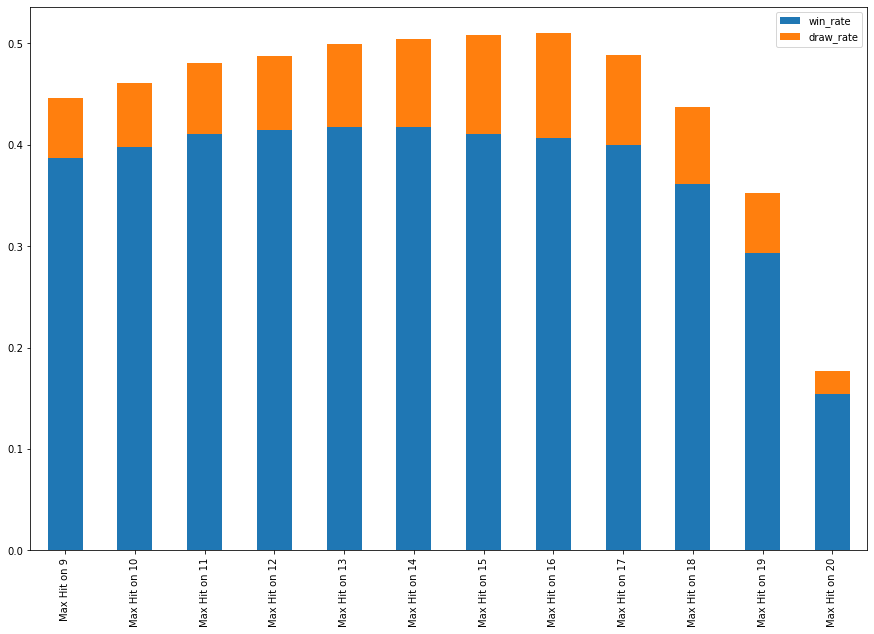

In [79]:
res.plot.bar(figsize=(15,10), stacked=True);